#  Week 8-  Quantum computation <a class="tocSkip">
    (c) Ariel Guerreiro 2023

Quantum computation is an exciting field that explores the use of quantum mechanical phenomena to perform computation. It promises to revolutionize the way we think about computing, offering the potential to solve problems beyond the reach of classical computers. Quantum computing is based on the principles of superposition and entanglement, which enable the qubits (quantum bits) to represent multiple states simultaneously. This allows quantum computers to perform computations much faster than classical computers.

In this notebook, we will introduce the Deutsch-Jozsa algorithm, Quantum Fourier Transform, Quantum phase estimation, Amplitude Estimation, and Solving a system of linear equations. These are some of the most important quantum algorithms that have been developed to date, and they demonstrate the power and potential of quantum computing. We will use Qiskit to implement and simulate these algorithms and explore their behavior on both simulated and real quantum hardware. This exercise will provide a practical introduction to quantum computing and showcase some of the capabilities of Qiskit as a powerful tool for quantum algorithm design and simulation.

# Before we start... <a class="tocSkip">
 
  Let us begin by runnning the initialization cell
    
$$
\def\ket#1{\left|#1\right\rangle }%
\def\bra#1{\left\langle #1\right|}%
\def\braket#1#2{\langle#1|#2\rangle}%
$$
   

In [17]:
import numpy as np
import math as mt
import scipy as sp
import matplotlib.pyplot as plt
import random
import re             # regular expressions module

from pylab import plot
from qiskit import *
from qiskit.visualization import *

# importing Qiskit
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute






%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # Makes the images fit
#import qiskit.tools.jupyter
#%qiskit_version_table
#%qiskit_copyright


# Deutsch-Jozsa algorithm: an example of a superperformant quantum algorithm

 

The Deutsch-Jozsa algorithm [1], was the first example of a quantum algorithm that outperforms the best classical algorithm, thus demonstrating that there can be advantages of a quantum computer over conventional classical computers.

To explain this algorithm, we start with an early and simpler algorithm: the Deutsch algorithm.

## The Deutsch algorithm

Assume we are given an unknown function $f$. By this we imply that we can utilize the function $f$, however we don't have the foggiest idea what is the mapping produced by it between the elements of domain and the possible images. Such function is usually refered as an oracle. In this context, an oracle  is simply an operation that has some property that you don't know, and are trying to find out. The term "black box" is used equivalently, to convey the idea that it's just a box that you can't see inside, and hence you don't know what it's doing. All you know is that you can supply inputs and receive outputs.

In particular, we consider a simple function that maps the input data data, either $0$ or $1$, into either $0$ or $1$. Accordingly, when we feed $f$ the data sources $0$ and $1$, the function will be describable by a combination  of the four after potential outcomes:
$$f(0)=0\ or\ f(0)=1$$
$$f(1)=0\ or\ f(1)=1$$

In light of these potential outcomes, we can say that $f$ is either a "balanced" or "constant" function. 
A "balanced" function implies that $f$ yields as many 0's as 1's, e.g. 
$$f(0) → 1 $$
$$f(1) → 0.$$ 
On the other hand, a constant function yield either all 0's or all 1's, e.g. 
$$f(0) → 1 $$
$$f(1) → 0.$$ 
So at that point, given this baffling function $f$, what is the minimum number of necessary to decide if it is "balanced" or "constant" function? 

Indeed, we should addopy a classical approach. Since we can just work with classical bits, suppose we feed the function a 0, and we get back a 1. So now we know that $f(0) → 1$. However, in light of this result, could  we infer the result for f(1), or in other words to determine wether $f$ is "balanced" or "constant"? The appropriate response is no. The data we got from applying the function $f$ is insufficient to decide wether it is a "balanced" or "constant" function. 

In the event that we get $f(1) → 1$, we conclude that $f$ is "constant", while in the event that we get $f(1) → 0$, we will presume that it is "balanced". In this way, we need to compute the function $f$ twice to chracterize it.

The code used in a classical computer to implement the classicla characterization algorithm would look something like this:

In [ ]:
def blackbox_f():
    def F1(x):
        return 0
    def F2(x):
        return 1
    def F3(x):
        return x%2
    def F4(x):
        return (x+1)%2
        
    functions = [F1,F2,F3,F4]
    r = int (mt.floor(4 * np.random.rand()))
    
    f = functions[r]
    return f
    
F = blackbox_f()

print('f(0): ', F(0))
print('f(1): ', F(1))

if (F(0)==F(1)):
    print('Conclusion: f is constant.')
else:
    print('Conclusion: f is balanced.')

When we consider the quantum equivalent of this problem, we notice that $f$ cannot be defined in the same way. While the classical version of $f$ converted classical bits into bits, the quantum counterpart converts a state of a qubit into the state of a qubit, following an unitary transformation.

Just to show how things fail when we try to carry a classical function to a quantum computer, we take a naif approach and define a quantum transformation that in some way attempts to extend the previous classical function to work on a qubit. The idea is to define a linear transformation that maps the states $|0\rangle$ and $|1\rangle$ into $|0\rangle$ and $|1\rangle$, just like its classical counterpart. Now, consider what would happen if we sent in a qubit in a superposition state between $|0\rangle$ and $|1\rangle$. For a constant $f$ we would get
$$
f\left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right)= \frac{f(|0\rangle) + f(|1\rangle)}{\sqrt{2}}=\frac{|1\rangle + |1\rangle}{\sqrt{2}}= \frac{2}{\sqrt{2}}|1\rangle,
$$
which is clearly non-unitary.  

To do this, we will describe the quantum operation $g$, which will integrate our classical function f in such a way that we still have a unit operator. We define $g$ following the ansatz
$$
g\left(|q_1\rangle \otimes |q_2\rangle\right)= |q_1\rangle \otimes |q_1 \oplus f(q_2) \rangle
$$
Let us explain this definition. 
First, we notice that instead of working with a single qubit we are using two, this is why the domain of the quantum operation is a two register state $|q_1\rangle \otimes |q_2\rangle$.
Second, the symbol $\oplus$ means addition modulo 2, defined as
$$
0 \oplus 0 = 0\\ 0 \oplus 1 = 1\\ 1 \oplus 0 = 1\\ 1 \oplus 1 = 0.
$$
For the elements of the computational basis of the two input registers the quantum operation $g$ produces the following map
$$
g\left(|0\rangle \otimes |0\rangle\right)= |0\rangle \otimes |0 \rangle \\
g\left(|0\rangle \otimes |1\rangle\right)= |0\rangle \otimes |1 \rangle \\
g\left(|1\rangle \otimes |0\rangle\right)= |0\rangle \otimes |1 \rangle \\
g\left(|1\rangle \otimes |1\rangle\right)= |0\rangle \otimes |0 \rangle 
$$
This operation sort of resembles our characterization $f$ in the sense that, if the two input qubits are identical, the second qubit of the output state is 0, and if they distinct the the second qubit of the output state is 1. 

This is precisely the key behind the equivalence between the quantum operation $g$ and the classical function $f$, say:
$$
f(0,1)\rightarrow (0,1):\\
g(|00\rangle) \rightarrow |00\rangle\\
g(|01\rangle) \rightarrow |01\rangle\\
g(|10\rangle) \rightarrow |11\rangle\\
g(|11\rangle) \rightarrow |10\rangle\\
$$
$$
    f(0,1)\rightarrow (1,0):\\
g(|00\rangle) \rightarrow |01\rangle\\
g(|01\rangle) \rightarrow |00\rangle\\
g(|10\rangle) \rightarrow |10\rangle\\
g(|11\rangle) \rightarrow |11\rangle\\
$$
$$
    f(0,1)\rightarrow (0,0):\\
g(|00\rangle) \rightarrow |00\rangle\\
g(|01\rangle) \rightarrow |01\rangle\\
g(|10\rangle) \rightarrow |10\rangle\\
g(|11\rangle) \rightarrow |11\rangle\\
$$
$$
    f(0,1)\rightarrow (1,1):\\
g(|00\rangle) \rightarrow |01\rangle\\
g(|01\rangle) \rightarrow |00\rangle\\
g(|10\rangle) \rightarrow |11\rangle\\
g(|11\rangle) \rightarrow |10\rangle\\
$$

Notice that this operation $g$ is able to handle a superposition
$$
g\left(|0\rangle \otimes \frac{|0\rangle + |1\rangle}{\sqrt{2}}\right)= \frac{g(|0\rangle \otimes|0\rangle) + g(|0\rangle \otimes|1\rangle)}{\sqrt{2}}=\frac{1}{\sqrt{2}}\left(|0\rangle \otimes |1\rangle   + |0\rangle \otimes |0\rangle\right) ,
$$

So let us look how the equivalent quantum circuit would work.

In [195]:
def blackbox_g(qc, q_reg):
    f_type=['f(0,1)->(0,1)','f(0,1)->(1,0)','f(0,1)->(0,0)','f(0,1)->(1,1)']
    
    r = int (mt.floor(4 * np.random.rand()))
    
    if r==0: 
        qc.cx(q_reg[0],q_reg[1])
    if r==1:
        qc.x(q_reg[0])
        qc.cx(q_reg[0],q_reg[1])
        qc.x(q_reg[0])
    if r==2:
        qc.id(q_reg[0])
        qc.id(q_reg[1])
    if r==3:
        qc.x(q_reg[1])
 
    return f_type[r]

# Initializing a two-qubit quantum state #00 and 01
initial_state = [
    1/mt.sqrt(2)+0.j,
    1/mt.sqrt(2)+0.j,
    0,
    0]

# Create a Quantum Circuit acting on a quantum register of 1 qubits and 2 bits
q = QuantumRegister(2, name = 'q')
circuit0 = QuantumCircuit(q,name='qc')
# Create the superposition state to show that things are working
circuit0.initialize(initial_state, [q[0],q[1]])


#Apply g (which is equivalent to f)
f = blackbox_g(circuit0, q)

simulator = BasicAer.get_backend('statevector_simulator') # the device to run on
result = execute(circuit0, simulator).result()
final_state = result.get_statevector(circuit0, decimals=16)

print('Initial state:\t', initial_state[0],' |00>',initial_state[1],' |01>',initial_state[2],' |10>',initial_state[3],' |11>')
print('Final state:\t', final_state[0],' |00>',final_state[1],' |01>',final_state[2],' |10>',final_state[3],' |11>')


Initial state:	 (0.7071067811865475+0j)  |00> (0.7071067811865475+0j)  |01> 0  |10> 0  |11>
Final state:	 0j  |00> (0.7071067811865476+0j)  |01> (0.7071067811865475+0j)  |10> 0j  |11>


## Deutsch-Jozsa algorithm (n-bit extension)

The Deutsch-Jozsa problem is an $n$-bit extension of the single bit Deutsch problem where are given a hidden function $f$, which takes as input vector of bits, and returns either $0$ or $1$, such that
$$
f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$$
Again, this function is guaranteed to either be balanced or constant. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant. 


Also and classicaly, in the best case two queries two queries are sufficient to determine whether the hidden Boolean function, $f(x)$, is balanced. For example, if we test $f(0,0,0,...)\rightarrow 0$ and $f(1,0,0,...) \rightarrow 1$ in the two queries, then we know the function is balanced as we have obtained the two different outputs.  

In the worst case, if we continue to see the same output for each input we try, we will have to check exactly half of all possible inputs plus one in order to be certain that $f(x)$ is constant. Since the total number of possible inputs is $2^n$, this implies that we need $2^{n-1}+1$ trial inputs to be certain that $f(x)$ is constant in the worst case. For example, for a $4$-bit string, if we checked $8$ out of the $16$ possible combinations, getting all $0$'s, it is still possible that the $9^\textrm{th}$ input returns a $1$ and $f(x)$ is balanced. Probabilistically, this is a very unlikely event. In fact, if we get the same result continually in succession, we can express the probability that the function is constant as a function of $k$ inputs as:

$$ P_\textrm{constant}(k) = 1 - \frac{1}{2^{k-1}} \qquad \textrm{for } k \leq 2^{n-1}$$

Realistically, we could opt to truncate our classical algorithm early, say if we were over x% confident. But if we want to be 100% confident, we would need to check $2^{n-1}+1$ inputs.

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. 

Now, let's go through the steps of the Deutsch algorithm but now with a twist, thus generalizing it to a n-bit problem:




Prepare a quantum register with $n+1$ qubits. The first $n$ qubits are initialised to $|0\rangle$, while the last qubit register is initialised to $|1\rangle$:

     

$$\vert \psi_0 \rangle = \vert x \rangle \otimes \vert 1 \rangle =\vert 0 \rangle^{\otimes n} \otimes \vert 1 \rangle$$
with $\vert x \rangle= \vert 0 \rangle^{\otimes n} $.



In [256]:
n=4
qc=QuantumCircuit(n+1,n)
qc.x(n)

Apply a Hadamard gate to each qubit:
        

$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$

Notice that for the qubits in the ground state we get $\vert 0\rangle \rightarrow \frac{1}{\sqrt{2}}\vert x\rangle$ while for the excited state $\vert 1\rangle \rightarrow\left(|0\rangle - |1 \rangle \right)$.


In [257]:
for i in range(n+1):
    qc.h(i)


Apply the quantum oracle $\vert x\rangle \vert y\rangle$ to $\vert x\rangle \vert y \oplus f(x)\rangle$:
        $$
            \begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}
        $$
       
since for each $x,f(x)$ is either $0$ or $1$. Again notice that this oracle is a form of generalization of the quantum operation $g$ used in the Deutsch algorithm.


In [258]:
def quantum_oracle(qc,n):
    r = int (mt.floor(2 * np.random.rand()))

    if r==0: 
        for i in range(n):
            if i%2==0:
                qc.x(i)
    if r==1:
        for i in range(n):
            qc.x(i)

In [259]:
quantum_oracle(qc,n)


At this point the last qubit  may be ignored. Apply a Hadamard gate to each of the first n qubits:
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned}
        $$
       
where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ is the sum of the bitwise product.


In [260]:
for i in range(n):
    qc.h(i)


Measure the first n qubits. Notice that the probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$, which evaluates to $1$ if $f(x)$ is constant and $0$ if $f(x)$ is balanced. 


In [261]:
for i in range(n):
    qc.measure(i,i)

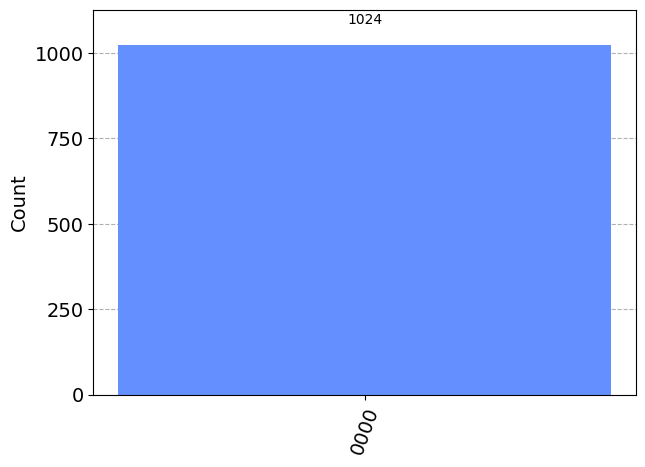

In [262]:
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(qc).result()
answer = results.get_counts()

plot_histogram(answer)

**Exercises:**
    
1. Develop a quantum circuit to test if the "blackbox_g" is working for a broad sample of states in the Hilbert space of the two qubit register.


$$
f(0,1)\rightarrow (0,1):\\
g(|00\rangle) \rightarrow |00\rangle\\
g(|01\rangle) \rightarrow |01\rangle\\
g(|10\rangle) \rightarrow |11\rangle\\
g(|11\rangle) \rightarrow |10\rangle\\
$$
$$
    f(0,1)\rightarrow (1,0):\\
g(|00\rangle) \rightarrow |01\rangle\\
g(|01\rangle) \rightarrow |00\rangle\\
g(|10\rangle) \rightarrow |10\rangle\\
g(|11\rangle) \rightarrow |11\rangle\\
$$
$$
    f(0,1)\rightarrow (0,0):\\
g(|00\rangle) \rightarrow |00\rangle\\
g(|01\rangle) \rightarrow |01\rangle\\
g(|10\rangle) \rightarrow |10\rangle\\
g(|11\rangle) \rightarrow |11\rangle\\
$$
$$
    f(0,1)\rightarrow (1,1):\\
g(|00\rangle) \rightarrow |01\rangle\\
g(|01\rangle) \rightarrow |00\rangle\\
g(|10\rangle) \rightarrow |11\rangle\\
g(|11\rangle) \rightarrow |10\rangle\\
$$

In [233]:
def confirm(i,f,f_type):
    f_sis=['f(0,1)->(0,1)','f(0,1)->(1,0)','f(0,1)->(0,0)','f(0,1)->(1,1)']

    if f_type==f_sis[0]:
        assert(mt.isclose(i[0].real,f[0].real,abs_tol = 0.0001))
        assert(mt.isclose(i[1].real,f[1].real,abs_tol = 0.0001))
        assert(mt.isclose(i[2].real,f[3].real,abs_tol = 0.0001))
        assert(mt.isclose(i[3].real,f[2].real,abs_tol = 0.0001))
        assert(mt.isclose(i[0].imag,f[0].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[1].imag,f[1].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[2].imag,f[3].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[3].imag,f[2].imag,abs_tol = 0.0001))
    if f_type==f_sis[1]:
        assert(mt.isclose(i[0].real,f[1].real,abs_tol = 0.0001))
        assert(mt.isclose(i[1].real,f[0].real,abs_tol = 0.0001))
        assert(mt.isclose(i[2].real,f[2].real,abs_tol = 0.0001))
        assert(mt.isclose(i[3].real,f[3].real,abs_tol = 0.0001))
        assert(mt.isclose(i[0].imag,f[1].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[1].imag,f[0].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[2].imag,f[2].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[3].imag,f[3].imag,abs_tol = 0.0001))
    if f_type==f_sis[2]:
        assert(mt.isclose(i[0].real,f[0].real,abs_tol = 0.0001))
        assert(mt.isclose(i[1].real,f[1].real,abs_tol = 0.0001))
        assert(mt.isclose(i[2].real,f[2].real,abs_tol = 0.0001))
        assert(mt.isclose(i[3].real,f[3].real,abs_tol = 0.0001))
        assert(mt.isclose(i[0].imag,f[0].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[1].imag,f[1].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[2].imag,f[2].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[3].imag,f[3].imag,abs_tol = 0.0001))
    if f_type==f_sis[3]:
        assert(mt.isclose(i[0].real,f[1].real,abs_tol = 0.0001))
        assert(mt.isclose(i[1].real,f[0].real,abs_tol = 0.0001))
        assert(mt.isclose(i[2].real,f[3].real,abs_tol = 0.0001))
        assert(mt.isclose(i[3].real,f[2].real,abs_tol = 0.0001))
        assert(mt.isclose(i[0].imag,f[1].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[1].imag,f[0].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[2].imag,f[3].imag,abs_tol = 0.0001))
        assert(mt.isclose(i[3].imag,f[2].imag,abs_tol = 0.0001))

In [234]:
def circuit(initial_state,qc,q):
    q = QuantumRegister(2, name = 'q')
    qc = QuantumCircuit(q,name='qc')

    qc.initialize(initial_state, [q[0],q[1]])

    f=blackbox_g(qc,q)

    simulator = BasicAer.get_backend('statevector_simulator') # the device to run on
    result = execute(qc, simulator).result()
    final_state = result.get_statevector(qc, decimals=16)
    
    #print('Initial state:\t', initial_state[0],' |00>',initial_state[1],' |01>',initial_state[2],' |10>',initial_state[3],' |11>')
    #print('Final state:\t', final_state[0],' |00>',final_state[2],' |01>',final_state[1],' |10>',final_state[3],' |11>')
    
    confirm(initial_state,[final_state[0],final_state[2],final_state[1],final_state[3]],f)

In [235]:
theta=np.linspace(0,np.pi,10)
phi=np.linspace(0,2*np.pi,10)
lam=0
from tqdm import tqdm

for i in tqdm(range(len(theta))):
    for j in range(len(phi)):
            state=[mt.cos(theta[i]/2)**2,
                   (mt.cos(phi[j])+1j*mt.sin(phi[j]))*mt.sin(theta[i])/2,
                   (mt.cos(phi[j])+1j*mt.sin(phi[j]))*mt.sin(theta[i])/2,
                   (mt.cos(2*phi[j])+1j*mt.sin(2*phi[j]))*mt.sin(theta[i]/2)**2]
            circuit(state,qc,q)

100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


In [236]:
print("It worked yay")

It worked yay



2. Implement the Deutsch-Jozsa algorithm for n=1 and n=2.
    


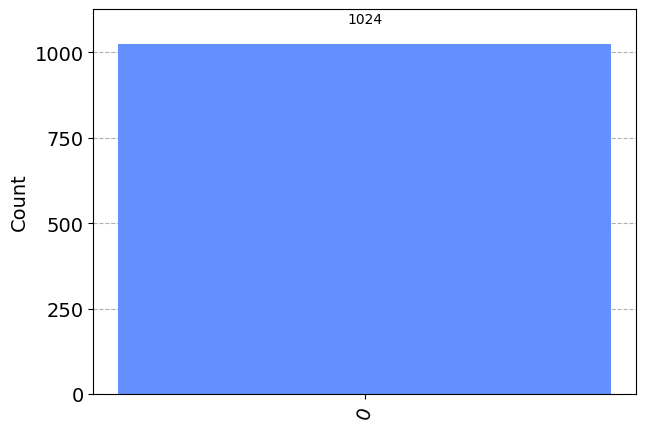

In [237]:
n=1

qc=QuantumCircuit(n+1,n)
qc.x(n)
for i in range(n+1):
    qc.h(i)

quantum_oracle(qc,n)
for i in range(n):
    qc.h(i)
for i in range(n):
    qc.measure(i,i)
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(qc).result()
answer = results.get_counts()

plot_histogram(answer)

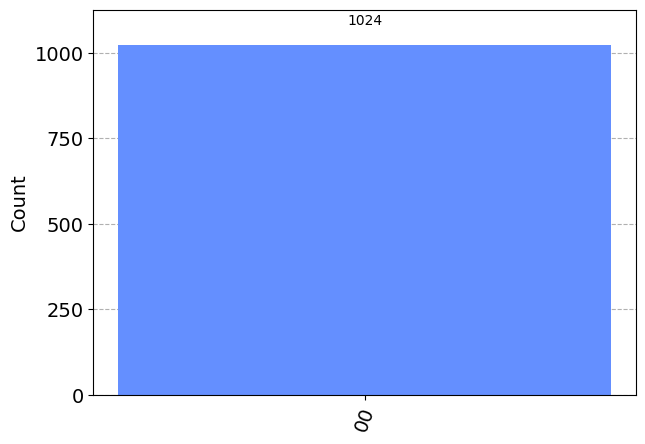

In [238]:
n=2

qc=QuantumCircuit(n+1,n)
qc.x(n)
for i in range(n+1):
    qc.h(i)

quantum_oracle(qc,n)

for i in range(n):
    qc.h(i)
    
for i in range(n):
    qc.measure(i,i)
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(qc).result()
answer = results.get_counts()

plot_histogram(answer)

### Advanced exercises <a class="tocSkip">
3. Implement the Deutsch-Jozsa algorithm for a general n.
    


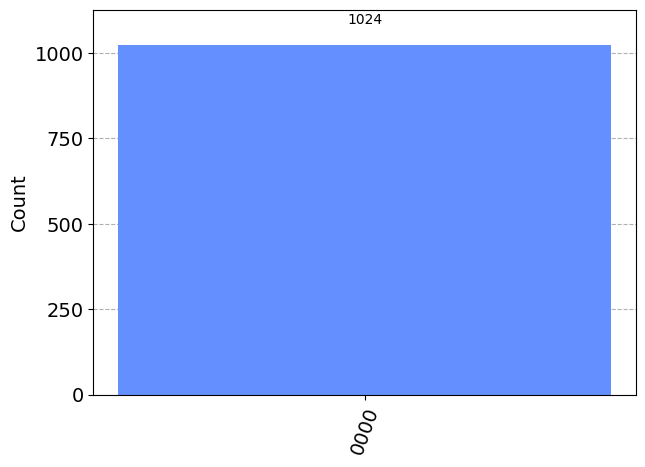

In [255]:
n=4

qc=QuantumCircuit(n+1,n)
qc.x(n)
for i in range(n+1):
    qc.h(i)

quantum_oracle(qc,n)

for i in range(n):
    qc.h(i)

for i in range(n):
    qc.measure(i,i)
    
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(qc).result()
answer = results.get_counts()

plot_histogram(answer)

4. Run the algorithm in IBM computer. So, do you not have a perfect oracle?

<div class="alert alert-success">
<b>Today's afterthoughts:</b>
Are you motivated to learn quantum computing? Why?
</div>


  

